## 5_Data Normalization

1. Data in use: RP_MDATA_20200212D
2. Moving average: date +- 45 days
3. Inactive siteID will be opted out when there is no RunDataID within 90days
4. Display siteID given active period
5. Count active RundataID on a moving average for each site

### Data Preprocessing

In [5]:
!pip install python-dateutil

import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil import parser
from collections import MutableMapping 
from matplotlib import pyplot as plt

%matplotlib inline

In [22]:
# Upload Files
RP_0212 = pd.read_csv('data_raw\\biofire\\RP_MDATA_20200212D.csv')

C:\Users\Sean\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
#Data Preprocessing
RP_0212[1:3]

,RunDataID,StartTime,InstrumentSerialNumber,FlaggedAsValidation,InstitutionID,ZipCode,TargetName,TargetShortName,AssayName,ResultType,TargetResult,AssayResult,Region,Country,InstrumentVersion,PouchTitle
1,gAAAAABeRDk9Meol3mQtnVm2iyw4NnCbwjYRulSnc4MqGM...,2015-11-11 05:16:06.000,gAAAAABeRDnh3jSZXVlnGwF2Z7ZzTyppxHdkZRWLZQ4skg...,0,gAAAAABeRDk9Meol3mQtnVm2iyw4NnCbwjYRulSnc4MqGM...,46601,PCR1 Control,NaN,PCR1,control,Pass,Positive,IN,United States of America,FA1.5,Respiratory_Panel
2,gAAAAABeRDk9Meol3mQtnVm2iyw4NnCbwjYRulSnc4MqGM...,2015-11-11 05:16:06.000,gAAAAABeRDnh3jSZXVlnGwF2Z7ZzTyppxHdkZRWLZQ4skg...,0,gAAAAABeRDk9Meol3mQtnVm2iyw4NnCbwjYRulSnc4MqGM...,46601,PCR2 Control,NaN,PCR2,control,Pass,Positive,IN,United States of America,FA1.5,Respiratory_Panel


In [24]:
# Retain Respiratory_Panel Only
RP_0212_1 = RP_0212.copy()
RP_0212_1 = RP_0212_1[RP_0212_1.PouchTitle == 'Respiratory_Panel']
RP_0212_1['PouchTitle'].unique()
RP_0212_1 = RP_0212_1.drop(columns = 'PouchTitle')

In [25]:
#Create Datetime from string to %y-%m-%d format
RP_0212_2 = RP_0212_1.copy()
RP_2012_time = []
for i in RP_0212_2['StartTime']:
    j = parser.parse(i).strftime('%Y-%m-%d')
    RP_2012_time.append(j)
RP_0212_2['DateTime'] = RP_2012_time

In [26]:
#Number of all participant institutes
RP_0212_3 = RP_0212_2.copy()
len(RP_0212_3['InstitutionID'].unique())

82

### Create Panel

In [77]:
#Create a Panel
RP_Panel = pd.DataFrame(columns = ['index','DateTime', 'Active_Sites','Total_Sites','Sites_Active_Ratio','Total_SitesTUR'])

In [82]:
#Create date range
#Has to be roughly 45 days before and after the range, and trancate later
dateRange = []
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
for result in perdelta(date(2011,8,15),date(2020,3,31), timedelta(days=1)):
    dateRange.append(result)

In [83]:
RP_Panel['DateTime'] = dateRange

In [84]:
#Parameters Setup
#Before and after day for moving averages
DayRange = 45
#Number of counts minimum for counts() per sites per day
minTUR = 1

In [28]:
Unique_sites = pd.DataFrame(columns = ['index','InstitutionID'])
Unique_sites['InstitutionID'] = RP_0212_3['InstitutionID'].unique()
index_us = []
c_US = 0
for i in Unique_sites['InstitutionID']:
    c_US += 1
    index_us.append(c_US)
Unique_sites['index'] = index_us

In [30]:
#Flatten the nested dict
Unique_sites_dict = Unique_sites.set_index('InstitutionID').to_dict()
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)
Unique_sites_dict = flatten(Unique_sites_dict)

In [87]:
index_RP = []
c_RP = 0
for i in RP_Panel['DateTime']:
    c_RP += 1
    index_RP.append(c_RP)
RP_Panel['index'] = index_RP

In [88]:
sortedRP_0212 = RP_0212_3['DateTime'].value_counts().reset_index()
sortedRP_0212 = sortedRP_0212.sort_values('index')
sortedRP = pd.DataFrame(columns = ['index','DateTime','Counts'])
sortedRP['DateTime'] = sortedRP_0212['index']
sortedRP['Counts'] = sortedRP_0212['DateTime']
index_sortedRP = []
c_sortedRP = 0
for i in sortedRP['DateTime']:
    c_sortedRP += 1
    index_sortedRP.append(c_sortedRP)
sortedRP['index'] = index_sortedRP
sortedRP = sortedRP.reset_index()
sortedRP = sortedRP.drop(columns = ['level_0'])

In [27]:
RP_0212_4 = RP_0212_3.copy()

In [31]:
RP_0212_4['InstitutionID'] = RP_0212_4['InstitutionID'].replace(Unique_sites_dict)

#### Active Sites (Nominator)

In [17]:
RP_0212_5 = RP_0212_4.copy()

In [71]:
RP_Panel_AS = []
for i in RP_Panel['DateTime']:
    c_ActiveSites = 0
    selected_ActiveSites = (RP_0212_4['DateTime'] == str(i))
    RP_0212_5 = RP_0212_4.loc[selected_ActiveSites]
    c_ActiveSites = len(RP_0212_5['InstitutionID'].unique())
    RP_Panel_AS.append(c_ActiveSites)

In [124]:
RP_Panel['Active_Sites']= RP_Panel_AS

#### Denominator

In [158]:
RP_Panel_TS = []
for i in RP_Panel['index']:
    if i < 46:
        RP_Panel_TS.append(0)
    elif i > RP_Panel['index'].count()- 46:
        RP_Panel_TS.append(0)
    else:
        c_TotalSites = 0
        m = RP_Panel.iloc[i]['DateTime']+timedelta(days=-DayRange)
        n = RP_Panel.iloc[i]['DateTime']+timedelta(days=DayRange)
        selected_TS = (RP_0212_4['DateTime'] >= str(m)) & (RP_0212_4['DateTime'] <= str(n))
        RP_0212_4_TS = RP_0212_4.loc[selected_TS]
        c_TotalSites = len(RP_0212_4_TS['InstitutionID'].unique())
        RP_Panel_TS.append(c_TotalSites)

In [159]:
RP_Panel['Total_Sites']= RP_Panel_TS

#### Ratio

In [248]:
RP_Panel['Sites_Active_Ratio'] = RP_Panel['Active_Sites']/RP_Panel['Total_Sites']

In [260]:
RP_Panel = RP_Panel.replace([np.inf, -np.inf], np.nan)
RP_Panel['Sites_Active_Ratio'] = RP_Panel['Sites_Active_Ratio'].fillna(0)

#### Total_SitesTUR

In [275]:
RP_Panel_TUR = []
#for i in RP_Panel['index']:
#    if RP_Panel.iloc[i-1]['Sites_Active_Ratio'] < 0.1:
#        RP_Panel_TUR.append(0)
#    else:
for i in RP_Panel['DateTime']:
    c_TUR = 0
    selected_TUR = (RP_0212_4['DateTime'] == str(i))
    RP_0212_5 = RP_0212_4.loc[selected_TUR]
    c_TUR = len(RP_0212_5['RunDataID'].unique())
    RP_Panel_TUR.append(c_TUR)

In [276]:
RP_Panel['Total_SitesTUR'] = RP_Panel_TUR

In [277]:
RP_Panel[1:400]

,index,DateTime,Active_Sites,Total_Sites,Sites_Active_Ratio,Total_SitesTUR
1,2,2011-08-16,0,0,0.0,0
2,3,2011-08-17,0,0,0.0,0
3,4,2011-08-18,0,0,0.0,0
4,5,2011-08-19,0,0,0.0,0
5,6,2011-08-20,0,0,0.0,0
6,7,2011-08-21,0,0,0.0,0
7,8,2011-08-22,0,0,0.0,0
8,9,2011-08-23,0,0,0.0,0
9,10,2011-08-24,0,0,0.0,0
10,11,2011-08-25,0,0,0.0,0


### Plot

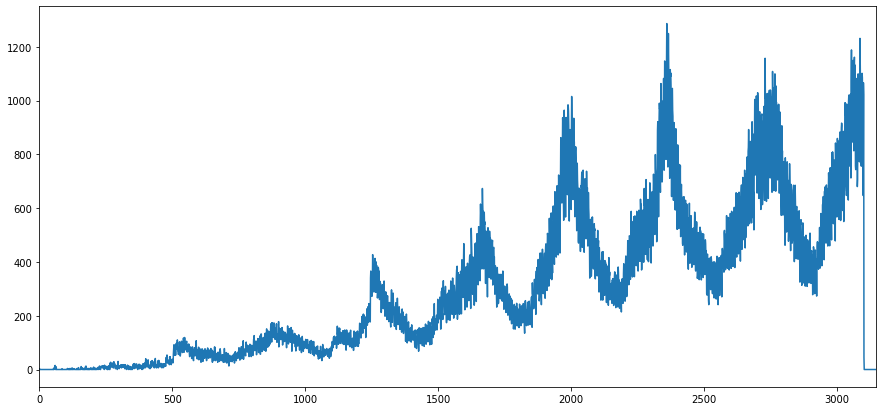

In [281]:
fig, ax = plt.subplots(figsize=(15,7))
RP_Panel['Total_SitesTUR'].plot()

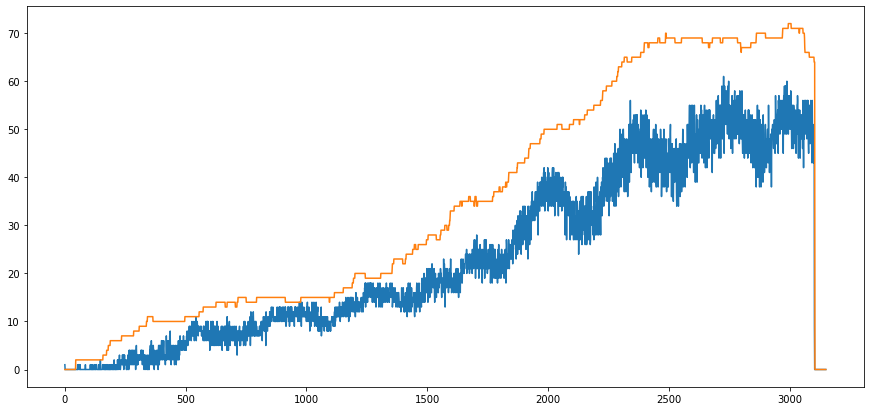

In [282]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(RP_Panel['Active_Sites'],label= 'Active_Sites')
ax.plot(RP_Panel['Total_Sites'],label= 'Total_Sites')

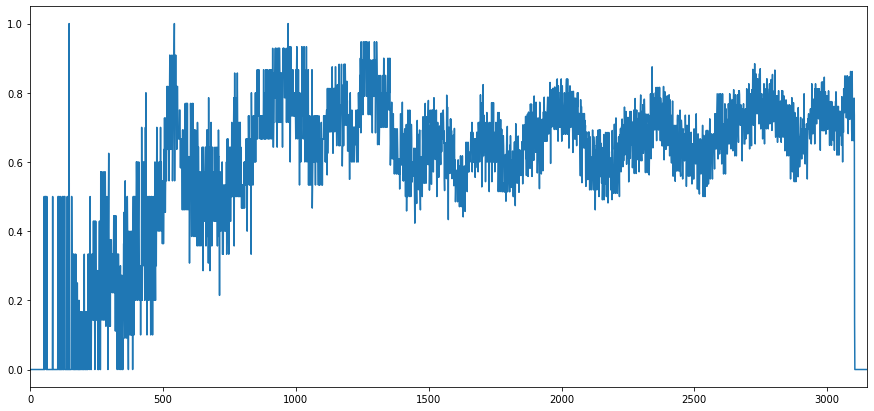

In [283]:
fig, ax = plt.subplots(figsize=(15,7))
RP_Panel['Sites_Active_Ratio'].plot()

In [284]:
RP_Panel.to_csv('C:\\Users\\Sean\\Desktop\\STAT 6950\\data_raw\\RP_Panel.csv', index = True)

## Recall

In [3]:
RP_Panel_1 = pd.read_csv('data_raw\\RP_Panel.csv')

In [7]:
RP_Panel_1 = RP_Panel_1.drop(columns = ['Unnamed: 0'])

In [14]:
RP_Panel_1['TURperSites_TS'] = RP_Panel_1['Total_SitesTUR']/RP_Panel_1['Total_Sites']
RP_Panel_1 = RP_Panel_1.replace([np.inf, -np.inf], np.nan)
RP_Panel_1['TURperSites_TS'] = RP_Panel_1['TURperSites_TS'].fillna(0)

In [15]:
RP_Panel_1['TURperSites_AS'] = RP_Panel_1['Total_SitesTUR']/RP_Panel_1['Active_Sites']
RP_Panel_1 = RP_Panel_1.replace([np.inf, -np.inf], np.nan)
RP_Panel_1['TURperSites_AS'] = RP_Panel_1['TURperSites_AS'].fillna(0)

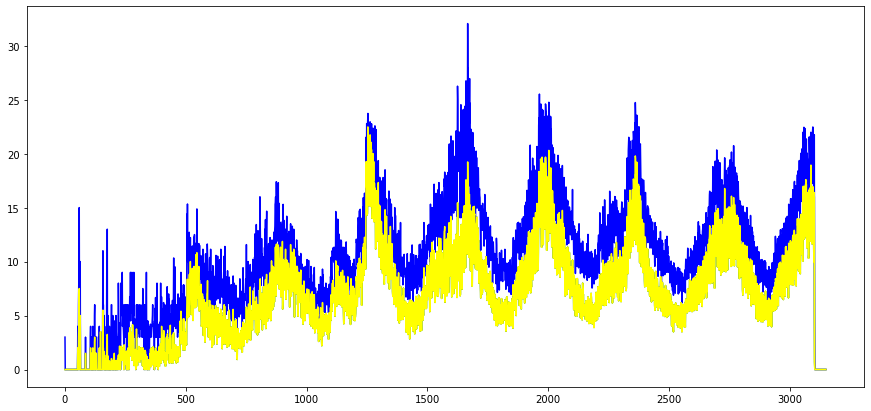

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(RP_Panel_1['TURperSites_TS'],color="green", label= 'TURperSites_TS')
ax.plot(RP_Panel_1['TURperSites_AS'],color="blue", label= 'TURperSites_AS')
ax.plot(RP_Panel_1['TURperSites'],color="yellow",label= 'Total_Sites')

## Average Out the TUR (3-week average)

In [34]:
RP_Panel_TUR_AVG = []
for i in RP_Panel_1['index']:
    if i < 11:
        RP_Panel_TUR_AVG.append(0)
    elif i > RP_Panel_1['index'].count()- 11:
        RP_Panel_TUR_AVG.append(0)
    else:
        c_TUR_AVG = 0
        m = pd.to_datetime(RP_Panel_1.iloc[i]['DateTime'])+timedelta(days=-10)
        n = pd.to_datetime(RP_Panel_1.iloc[i]['DateTime'])+timedelta(days=10)
        selected_TUR_AVG = (RP_0212_4['DateTime'] >= str(m)) & (RP_0212_4['DateTime'] <= str(n))
        RP_0212_4_TUR_AVG = RP_0212_4.loc[selected_TUR_AVG]
        c_TUR_AVG = len(RP_0212_4_TUR_AVG['RunDataID'].unique())/21
        RP_Panel_TUR_AVG.append(c_TUR_AVG)

In [35]:
RP_Panel_1['TUR_21_AVG'] = RP_Panel_TUR_AVG

In [36]:
RP_Panel_1['TUR_21_AVG_TS'] = RP_Panel_1['TUR_21_AVG']/RP_Panel_1['Total_Sites']
RP_Panel_1 = RP_Panel_1.replace([np.inf, -np.inf], np.nan)
RP_Panel_1['TUR_21_AVG_TS'] = RP_Panel_1['TUR_21_AVG_TS'].fillna(0)

In [37]:
RP_Panel_1['TUR_21_AVG_AS'] = RP_Panel_1['TUR_21_AVG']/RP_Panel_1['Active_Sites']
RP_Panel_1 = RP_Panel_1.replace([np.inf, -np.inf], np.nan)
RP_Panel_1['TUR_21_AVG_AS'] = RP_Panel_1['TUR_21_AVG_AS'].fillna(0)

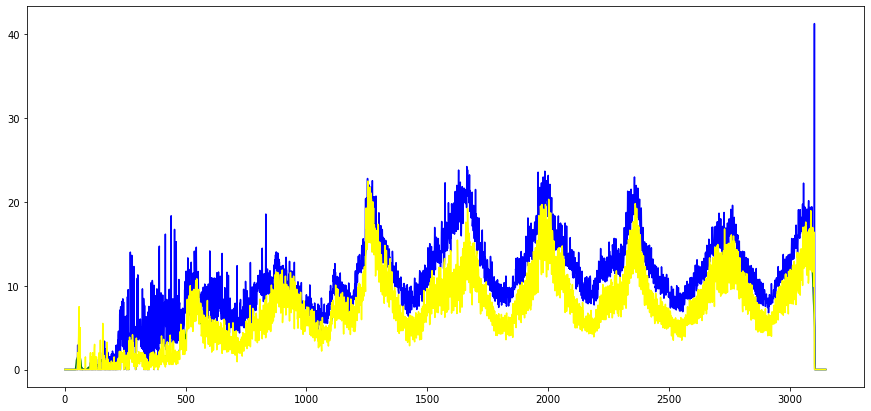

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(RP_Panel_1['TUR_21_AVG_TS'],color="green", label= 'TUR_21_AVG_TS')
ax.plot(RP_Panel_1['TUR_21_AVG_AS'],color="blue", label= 'TUR_21_AVG_AS')
ax.plot(RP_Panel_1['TURperSites'],color="yellow",label= 'Total_Sites')